# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
# OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 100

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 100

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_AdamW_amsgrad'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../../data", seceted_dataset=DATASET)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
scheduler = ExponentialLR(optimizer, gamma=0.95)

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.001

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/100] :


1 Train: 100%|███████| 391/391 [00:23<00:00, 16.84it/s]

Train Loss: 1.7091 | Train Acc: 37.33%


Test  Loss: 2.1212 | Test Acc: 28.22%
updated best eval loss : 2.1212031509302838
--------------------------------------------------
[Epoch 2/100] :


2 Train: 100%|███████| 391/391 [00:30<00:00, 13.01it/s]


Train Loss: 1.2926 | Train Acc: 54.04%
Test  Loss: 1.8576 | Test Acc: 39.58%
updated best eval loss : 1.8576252490659304
--------------------------------------------------
[Epoch 3/100] :


3 Train: 100%|███████| 391/391 [00:30<00:00, 12.63it/s]


Train Loss: 1.1080 | Train Acc: 60.78%
Test  Loss: 1.5500 | Test Acc: 50.64%
updated best eval loss : 1.5499938228462316
--------------------------------------------------
[Epoch 4/100] :


4 Train: 100%|███████| 391/391 [00:29<00:00, 13.48it/s]


Train Loss: 0.9828 | Train Acc: 65.56%
Test  Loss: 1.2518 | Test Acc: 57.47%
updated best eval loss : 1.2518424240848687
--------------------------------------------------
[Epoch 5/100] :


5 Train: 100%|███████| 391/391 [00:30<00:00, 13.00it/s]


Train Loss: 0.8998 | Train Acc: 68.56%
Test  Loss: 1.5926 | Test Acc: 55.87%
--------------------------------------------------
[Epoch 6/100] :


6 Train: 100%|███████| 391/391 [00:30<00:00, 13.00it/s]


Train Loss: 0.8444 | Train Acc: 70.66%
Test  Loss: 1.7393 | Test Acc: 51.93%
--------------------------------------------------
[Epoch 7/100] :


7 Train: 100%|███████| 391/391 [00:29<00:00, 13.18it/s]


Train Loss: 0.7971 | Train Acc: 72.24%
Test  Loss: 0.8063 | Test Acc: 72.38%
updated best eval loss : 0.8063444970529291
--------------------------------------------------
[Epoch 8/100] :


8 Train: 100%|███████| 391/391 [00:28<00:00, 13.68it/s]


Train Loss: 0.7631 | Train Acc: 73.32%
Test  Loss: 0.7705 | Test Acc: 74.21%
updated best eval loss : 0.7705412499512299
--------------------------------------------------
[Epoch 9/100] :


9 Train: 100%|███████| 391/391 [00:31<00:00, 12.31it/s]


Train Loss: 0.7251 | Train Acc: 74.80%
Test  Loss: 0.7130 | Test Acc: 75.97%
updated best eval loss : 0.7129924900924103
--------------------------------------------------
[Epoch 10/100] :


10 Train: 100%|██████| 391/391 [00:36<00:00, 10.85it/s]


Train Loss: 0.6958 | Train Acc: 75.75%
Test  Loss: 0.7598 | Test Acc: 74.16%
--------------------------------------------------
[Epoch 11/100] :


11 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.6783 | Train Acc: 76.29%
Test  Loss: 0.6138 | Test Acc: 78.70%
updated best eval loss : 0.6138228481706185
--------------------------------------------------
[Epoch 12/100] :


12 Train: 100%|██████| 391/391 [00:46<00:00,  8.35it/s]


Train Loss: 0.6544 | Train Acc: 77.28%
Test  Loss: 0.6539 | Test Acc: 76.67%
--------------------------------------------------
[Epoch 13/100] :


13 Train: 100%|██████| 391/391 [00:36<00:00, 10.80it/s]


Train Loss: 0.6311 | Train Acc: 78.18%
Test  Loss: 0.6239 | Test Acc: 78.98%
--------------------------------------------------
[Epoch 14/100] :


14 Train: 100%|██████| 391/391 [00:34<00:00, 11.27it/s]


Train Loss: 0.6161 | Train Acc: 78.62%
Test  Loss: 0.6266 | Test Acc: 78.22%
--------------------------------------------------
[Epoch 15/100] :


15 Train: 100%|██████| 391/391 [00:34<00:00, 11.46it/s]


Train Loss: 0.6027 | Train Acc: 79.06%
Test  Loss: 0.6838 | Test Acc: 76.97%
--------------------------------------------------
[Epoch 16/100] :


16 Train: 100%|██████| 391/391 [00:36<00:00, 10.71it/s]


Train Loss: 0.5816 | Train Acc: 79.78%
Test  Loss: 0.6282 | Test Acc: 78.63%
--------------------------------------------------
[Epoch 17/100] :


17 Train: 100%|██████| 391/391 [00:35<00:00, 11.03it/s]


Train Loss: 0.5716 | Train Acc: 80.11%
Test  Loss: 0.6672 | Test Acc: 76.93%
--------------------------------------------------
[Epoch 18/100] :


18 Train: 100%|██████| 391/391 [00:33<00:00, 11.56it/s]


Train Loss: 0.5589 | Train Acc: 80.27%
Test  Loss: 0.6378 | Test Acc: 78.75%
--------------------------------------------------
[Epoch 19/100] :


19 Train: 100%|██████| 391/391 [00:35<00:00, 11.05it/s]


Train Loss: 0.5444 | Train Acc: 80.95%
Test  Loss: 0.5816 | Test Acc: 80.22%
updated best eval loss : 0.5815940910502325
--------------------------------------------------
[Epoch 20/100] :


20 Train: 100%|██████| 391/391 [00:32<00:00, 11.94it/s]


Train Loss: 0.5384 | Train Acc: 81.44%
Test  Loss: 0.6046 | Test Acc: 79.45%
--------------------------------------------------
[Epoch 21/100] :


21 Train: 100%|██████| 391/391 [00:34<00:00, 11.18it/s]


Train Loss: 0.5217 | Train Acc: 81.83%
Test  Loss: 0.5512 | Test Acc: 81.55%
updated best eval loss : 0.5512422360951388
--------------------------------------------------
[Epoch 22/100] :


22 Train: 100%|██████| 391/391 [00:36<00:00, 10.83it/s]


Train Loss: 0.5168 | Train Acc: 81.92%
Test  Loss: 0.5843 | Test Acc: 80.08%
--------------------------------------------------
[Epoch 23/100] :


23 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.5076 | Train Acc: 82.38%
Test  Loss: 0.6925 | Test Acc: 76.83%
--------------------------------------------------
[Epoch 24/100] :


24 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.5001 | Train Acc: 82.73%
Test  Loss: 0.5773 | Test Acc: 80.53%
--------------------------------------------------
[Epoch 25/100] :


25 Train: 100%|██████| 391/391 [00:50<00:00,  7.77it/s]


Train Loss: 0.4981 | Train Acc: 82.61%
Test  Loss: 0.4701 | Test Acc: 83.68%
updated best eval loss : 0.47006712042832677
--------------------------------------------------
[Epoch 26/100] :


26 Train: 100%|██████| 391/391 [00:49<00:00,  7.98it/s]


Train Loss: 0.4828 | Train Acc: 83.14%
Test  Loss: 0.5741 | Test Acc: 80.86%
--------------------------------------------------
[Epoch 27/100] :


27 Train: 100%|██████| 391/391 [00:50<00:00,  7.71it/s]


Train Loss: 0.4749 | Train Acc: 83.57%
Test  Loss: 0.5243 | Test Acc: 81.57%
--------------------------------------------------
[Epoch 28/100] :


28 Train: 100%|██████| 391/391 [00:49<00:00,  7.91it/s]


Train Loss: 0.4676 | Train Acc: 83.84%
Test  Loss: 0.5366 | Test Acc: 82.15%
--------------------------------------------------
[Epoch 29/100] :


29 Train: 100%|██████| 391/391 [00:50<00:00,  7.73it/s]


Train Loss: 0.4647 | Train Acc: 83.89%
Test  Loss: 0.6493 | Test Acc: 78.58%
--------------------------------------------------
[Epoch 30/100] :


30 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.4581 | Train Acc: 83.98%
Test  Loss: 0.4448 | Test Acc: 84.81%
updated best eval loss : 0.44480931758880615
--------------------------------------------------
[Epoch 31/100] :


31 Train: 100%|██████| 391/391 [00:50<00:00,  7.70it/s]


Train Loss: 0.4500 | Train Acc: 84.40%
Test  Loss: 0.5027 | Test Acc: 83.19%
--------------------------------------------------
[Epoch 32/100] :


32 Train: 100%|██████| 391/391 [00:47<00:00,  8.15it/s]


Train Loss: 0.4422 | Train Acc: 84.63%
Test  Loss: 0.5825 | Test Acc: 80.07%
--------------------------------------------------
[Epoch 33/100] :


33 Train: 100%|██████| 391/391 [00:50<00:00,  7.78it/s]


Train Loss: 0.4408 | Train Acc: 84.50%
Test  Loss: 0.4892 | Test Acc: 83.38%
--------------------------------------------------
[Epoch 34/100] :


34 Train: 100%|██████| 391/391 [00:49<00:00,  7.96it/s]


Train Loss: 0.4374 | Train Acc: 84.60%
Test  Loss: 0.4757 | Test Acc: 84.19%
--------------------------------------------------
[Epoch 35/100] :


35 Train: 100%|██████| 391/391 [00:47<00:00,  8.18it/s]


Train Loss: 0.4200 | Train Acc: 85.28%
Test  Loss: 0.4712 | Test Acc: 83.92%
--------------------------------------------------
[Epoch 36/100] :


36 Train: 100%|██████| 391/391 [00:48<00:00,  8.04it/s]


Train Loss: 0.4211 | Train Acc: 85.21%
Test  Loss: 0.4766 | Test Acc: 83.92%
--------------------------------------------------
[Epoch 37/100] :


37 Train: 100%|██████| 391/391 [00:48<00:00,  8.08it/s]


Train Loss: 0.4157 | Train Acc: 85.57%
Test  Loss: 0.4432 | Test Acc: 85.06%
updated best eval loss : 0.44319835154316095
--------------------------------------------------
[Epoch 38/100] :


38 Train: 100%|██████| 391/391 [00:51<00:00,  7.62it/s]


Train Loss: 0.4121 | Train Acc: 85.66%
Test  Loss: 0.4029 | Test Acc: 86.50%
updated best eval loss : 0.4029309521370296
--------------------------------------------------
[Epoch 39/100] :


39 Train: 100%|██████| 391/391 [00:47<00:00,  8.16it/s]


Train Loss: 0.4056 | Train Acc: 85.78%
Test  Loss: 0.4801 | Test Acc: 84.17%
--------------------------------------------------
[Epoch 40/100] :


40 Train: 100%|██████| 391/391 [00:51<00:00,  7.56it/s]


Train Loss: 0.4041 | Train Acc: 85.97%
Test  Loss: 0.4508 | Test Acc: 84.83%
--------------------------------------------------
[Epoch 41/100] :


41 Train: 100%|██████| 391/391 [00:47<00:00,  8.15it/s]


Train Loss: 0.3944 | Train Acc: 86.17%
Test  Loss: 0.4530 | Test Acc: 84.89%
--------------------------------------------------
[Epoch 42/100] :


42 Train: 100%|██████| 391/391 [00:51<00:00,  7.65it/s]


Train Loss: 0.3972 | Train Acc: 86.14%
Test  Loss: 0.4385 | Test Acc: 85.11%
--------------------------------------------------
[Epoch 43/100] :


43 Train: 100%|██████| 391/391 [00:48<00:00,  8.04it/s]


Train Loss: 0.3924 | Train Acc: 86.42%
Test  Loss: 0.5342 | Test Acc: 82.22%
--------------------------------------------------
[Epoch 44/100] :


44 Train: 100%|██████| 391/391 [00:49<00:00,  7.87it/s]


Train Loss: 0.3934 | Train Acc: 86.33%
Test  Loss: 0.4266 | Test Acc: 85.80%
--------------------------------------------------
[Epoch 45/100] :


45 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.3881 | Train Acc: 86.51%
Test  Loss: 0.4302 | Test Acc: 85.60%
--------------------------------------------------
[Epoch 46/100] :


46 Train: 100%|██████| 391/391 [00:48<00:00,  8.08it/s]


Train Loss: 0.3772 | Train Acc: 86.72%
Test  Loss: 0.4680 | Test Acc: 84.69%
--------------------------------------------------
[Epoch 47/100] :


47 Train: 100%|██████| 391/391 [00:48<00:00,  8.01it/s]


Train Loss: 0.3814 | Train Acc: 86.65%
Test  Loss: 0.4188 | Test Acc: 86.03%
--------------------------------------------------
[Epoch 48/100] :


48 Train: 100%|██████| 391/391 [00:49<00:00,  7.95it/s]


Train Loss: 0.3723 | Train Acc: 87.08%
Test  Loss: 0.4660 | Test Acc: 84.59%
--------------------------------------------------
[Epoch 49/100] :


49 Train: 100%|██████| 391/391 [00:50<00:00,  7.80it/s]


Train Loss: 0.3752 | Train Acc: 86.96%
Test  Loss: 0.4601 | Test Acc: 84.63%
--------------------------------------------------
[Epoch 50/100] :


50 Train: 100%|██████| 391/391 [00:47<00:00,  8.23it/s]


Train Loss: 0.3618 | Train Acc: 87.25%
Test  Loss: 0.4465 | Test Acc: 85.10%
--------------------------------------------------
[Epoch 51/100] :


51 Train: 100%|██████| 391/391 [00:50<00:00,  7.70it/s]


Train Loss: 0.3696 | Train Acc: 87.06%
Test  Loss: 0.4223 | Test Acc: 86.16%
--------------------------------------------------
[Epoch 52/100] :


52 Train: 100%|██████| 391/391 [00:49<00:00,  7.87it/s]


Train Loss: 0.3587 | Train Acc: 87.31%
Test  Loss: 0.4082 | Test Acc: 87.01%
--------------------------------------------------
[Epoch 53/100] :


53 Train: 100%|██████| 391/391 [00:50<00:00,  7.77it/s]


Train Loss: 0.3563 | Train Acc: 87.54%
Test  Loss: 0.4502 | Test Acc: 85.93%
--------------------------------------------------
[Epoch 54/100] :


54 Train: 100%|██████| 391/391 [00:47<00:00,  8.19it/s]


Train Loss: 0.3538 | Train Acc: 87.72%
Test  Loss: 0.4622 | Test Acc: 85.07%
--------------------------------------------------
[Epoch 55/100] :


55 Train: 100%|██████| 391/391 [00:50<00:00,  7.80it/s]


Train Loss: 0.3459 | Train Acc: 87.96%
Test  Loss: 0.4435 | Test Acc: 85.79%
--------------------------------------------------
[Epoch 56/100] :


56 Train: 100%|██████| 391/391 [00:49<00:00,  7.96it/s]


Train Loss: 0.3485 | Train Acc: 87.74%
Test  Loss: 0.4823 | Test Acc: 84.81%
--------------------------------------------------
[Epoch 57/100] :


57 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.3432 | Train Acc: 88.00%
Test  Loss: 0.4317 | Test Acc: 85.86%
--------------------------------------------------
[Epoch 58/100] :


58 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.3458 | Train Acc: 87.96%
Test  Loss: 0.4714 | Test Acc: 84.78%
--------------------------------------------------
[Epoch 59/100] :


59 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.3413 | Train Acc: 87.94%
Test  Loss: 0.5093 | Test Acc: 83.92%
--------------------------------------------------
[Epoch 60/100] :


60 Train: 100%|██████| 391/391 [00:49<00:00,  7.93it/s]


Train Loss: 0.3398 | Train Acc: 88.17%
Test  Loss: 0.4128 | Test Acc: 86.15%
--------------------------------------------------
[Epoch 61/100] :


61 Train: 100%|██████| 391/391 [00:50<00:00,  7.80it/s]


Train Loss: 0.3370 | Train Acc: 88.16%
Test  Loss: 0.4586 | Test Acc: 85.19%
--------------------------------------------------
[Epoch 62/100] :


62 Train: 100%|██████| 391/391 [00:50<00:00,  7.73it/s]


Train Loss: 0.3338 | Train Acc: 88.44%
Test  Loss: 0.5244 | Test Acc: 83.00%
--------------------------------------------------
[Epoch 63/100] :


63 Train: 100%|██████| 391/391 [00:49<00:00,  7.96it/s]


Train Loss: 0.3358 | Train Acc: 88.23%
Test  Loss: 0.4261 | Test Acc: 86.27%
--------------------------------------------------
[Epoch 64/100] :


64 Train: 100%|██████| 391/391 [00:50<00:00,  7.80it/s]


Train Loss: 0.3256 | Train Acc: 88.49%
Test  Loss: 0.5088 | Test Acc: 83.99%
--------------------------------------------------
[Epoch 65/100] :


65 Train: 100%|██████| 391/391 [00:49<00:00,  7.96it/s]


Train Loss: 0.3278 | Train Acc: 88.37%
Test  Loss: 0.4650 | Test Acc: 84.77%
--------------------------------------------------
[Epoch 66/100] :


66 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.3238 | Train Acc: 88.65%
Test  Loss: 0.4145 | Test Acc: 86.20%
--------------------------------------------------
[Epoch 67/100] :


67 Train: 100%|██████| 391/391 [00:49<00:00,  7.86it/s]


Train Loss: 0.3270 | Train Acc: 88.68%
Test  Loss: 0.4129 | Test Acc: 86.26%
--------------------------------------------------
[Epoch 68/100] :


68 Train: 100%|██████| 391/391 [00:50<00:00,  7.73it/s]


Train Loss: 0.3209 | Train Acc: 88.64%
Test  Loss: 0.4356 | Test Acc: 86.41%
--------------------------------------------------
[Epoch 69/100] :


69 Train: 100%|██████| 391/391 [00:49<00:00,  7.88it/s]


Train Loss: 0.3173 | Train Acc: 88.93%
Test  Loss: 0.4433 | Test Acc: 85.90%
--------------------------------------------------
[Epoch 70/100] :


70 Train: 100%|██████| 391/391 [00:49<00:00,  7.90it/s]


Train Loss: 0.3117 | Train Acc: 89.16%
Test  Loss: 0.3847 | Test Acc: 87.56%
updated best eval loss : 0.3847266903406457
--------------------------------------------------
[Epoch 71/100] :


71 Train: 100%|██████| 391/391 [00:50<00:00,  7.70it/s]


Train Loss: 0.3179 | Train Acc: 88.93%
Test  Loss: 0.3984 | Test Acc: 87.48%
--------------------------------------------------
[Epoch 72/100] :


72 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.3169 | Train Acc: 88.88%
Test  Loss: 0.4671 | Test Acc: 85.26%
--------------------------------------------------
[Epoch 73/100] :


73 Train: 100%|██████| 391/391 [00:51<00:00,  7.60it/s]


Train Loss: 0.3106 | Train Acc: 89.12%
Test  Loss: 0.4140 | Test Acc: 86.87%
--------------------------------------------------
[Epoch 74/100] :


74 Train: 100%|██████| 391/391 [00:49<00:00,  7.89it/s]


Train Loss: 0.3057 | Train Acc: 89.13%
Test  Loss: 0.4082 | Test Acc: 86.58%
--------------------------------------------------
[Epoch 75/100] :


75 Train: 100%|██████| 391/391 [00:48<00:00,  7.98it/s]


Train Loss: 0.3106 | Train Acc: 89.14%
Test  Loss: 0.3879 | Test Acc: 87.52%
--------------------------------------------------
[Epoch 76/100] :


76 Train: 100%|██████| 391/391 [00:49<00:00,  7.96it/s]


Train Loss: 0.3034 | Train Acc: 89.33%
Test  Loss: 0.4291 | Test Acc: 86.38%
--------------------------------------------------
[Epoch 77/100] :


77 Train: 100%|██████| 391/391 [00:51<00:00,  7.66it/s]


Train Loss: 0.3007 | Train Acc: 89.37%
Test  Loss: 0.4830 | Test Acc: 85.38%
--------------------------------------------------
[Epoch 78/100] :


78 Train: 100%|██████| 391/391 [00:48<00:00,  8.06it/s]


Train Loss: 0.3011 | Train Acc: 89.39%
Test  Loss: 0.3864 | Test Acc: 87.59%
--------------------------------------------------
[Epoch 79/100] :


79 Train: 100%|██████| 391/391 [00:49<00:00,  7.96it/s]


Train Loss: 0.2975 | Train Acc: 89.62%
Test  Loss: 0.4425 | Test Acc: 86.13%
--------------------------------------------------
[Epoch 80/100] :


80 Train: 100%|██████| 391/391 [00:48<00:00,  8.13it/s]


Train Loss: 0.3017 | Train Acc: 89.36%
Test  Loss: 0.4017 | Test Acc: 87.30%
--------------------------------------------------
[Epoch 81/100] :


81 Train: 100%|██████| 391/391 [00:47<00:00,  8.16it/s]


Train Loss: 0.2932 | Train Acc: 89.72%
Test  Loss: 0.4090 | Test Acc: 86.93%
--------------------------------------------------
[Epoch 82/100] :


82 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.2957 | Train Acc: 89.53%
Test  Loss: 0.4249 | Test Acc: 87.31%
--------------------------------------------------
[Epoch 83/100] :


83 Train: 100%|██████| 391/391 [00:48<00:00,  8.09it/s]


Train Loss: 0.2930 | Train Acc: 89.72%
Test  Loss: 0.3958 | Test Acc: 87.64%
--------------------------------------------------
[Epoch 84/100] :


84 Train: 100%|██████| 391/391 [00:47<00:00,  8.15it/s]


Train Loss: 0.2868 | Train Acc: 90.01%
Test  Loss: 0.4344 | Test Acc: 86.48%
--------------------------------------------------
[Epoch 85/100] :


85 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.2885 | Train Acc: 89.90%
Test  Loss: 0.4037 | Test Acc: 87.48%
--------------------------------------------------
[Epoch 86/100] :


86 Train: 100%|██████| 391/391 [00:48<00:00,  8.04it/s]


Train Loss: 0.2875 | Train Acc: 89.82%
Test  Loss: 0.4227 | Test Acc: 86.63%
--------------------------------------------------
[Epoch 87/100] :


87 Train: 100%|██████| 391/391 [00:47<00:00,  8.16it/s]


Train Loss: 0.2892 | Train Acc: 89.83%
Test  Loss: 0.3896 | Test Acc: 87.72%
--------------------------------------------------
[Epoch 88/100] :


88 Train: 100%|██████| 391/391 [00:49<00:00,  7.83it/s]


Train Loss: 0.2831 | Train Acc: 90.09%
Test  Loss: 0.4230 | Test Acc: 86.71%
--------------------------------------------------
[Epoch 89/100] :


89 Train: 100%|██████| 391/391 [00:47<00:00,  8.24it/s]


Train Loss: 0.2859 | Train Acc: 90.03%
Test  Loss: 0.4525 | Test Acc: 86.02%
--------------------------------------------------
[Epoch 90/100] :


90 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.2882 | Train Acc: 89.93%
Test  Loss: 0.3804 | Test Acc: 87.82%
updated best eval loss : 0.3804072660358646
--------------------------------------------------
[Epoch 91/100] :


91 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.2856 | Train Acc: 90.08%
Test  Loss: 0.4743 | Test Acc: 85.50%
--------------------------------------------------
[Epoch 92/100] :


92 Train: 100%|██████| 391/391 [00:49<00:00,  7.85it/s]


Train Loss: 0.2763 | Train Acc: 90.36%
Test  Loss: 0.4072 | Test Acc: 87.73%
--------------------------------------------------
[Epoch 93/100] :


93 Train: 100%|██████| 391/391 [00:50<00:00,  7.79it/s]


Train Loss: 0.2729 | Train Acc: 90.29%
Test  Loss: 0.3845 | Test Acc: 87.71%
--------------------------------------------------
[Epoch 94/100] :


94 Train: 100%|██████| 391/391 [00:48<00:00,  8.00it/s]


Train Loss: 0.2803 | Train Acc: 90.19%
Test  Loss: 0.3918 | Test Acc: 88.06%
--------------------------------------------------
[Epoch 95/100] :


95 Train: 100%|██████| 391/391 [00:51<00:00,  7.64it/s]


Train Loss: 0.2782 | Train Acc: 90.23%
Test  Loss: 0.4010 | Test Acc: 87.22%
--------------------------------------------------
[Epoch 96/100] :


96 Train: 100%|██████| 391/391 [00:48<00:00,  8.03it/s]


Train Loss: 0.2708 | Train Acc: 90.45%
Test  Loss: 0.4286 | Test Acc: 86.44%
--------------------------------------------------
[Epoch 97/100] :


97 Train: 100%|██████| 391/391 [00:49<00:00,  7.91it/s]


Train Loss: 0.2744 | Train Acc: 90.34%
Test  Loss: 0.4025 | Test Acc: 87.51%
--------------------------------------------------
[Epoch 98/100] :


98 Train: 100%|██████| 391/391 [00:39<00:00,  9.86it/s]


Train Loss: 0.2683 | Train Acc: 90.64%
Test  Loss: 0.4396 | Test Acc: 86.40%
--------------------------------------------------
[Epoch 99/100] :


99 Train: 100%|██████| 391/391 [00:39<00:00,  9.89it/s]


Train Loss: 0.2692 | Train Acc: 90.50%
Test  Loss: 0.4465 | Test Acc: 86.61%
--------------------------------------------------
[Epoch 100/100] :


100 Train: 100%|█████| 391/391 [00:32<00:00, 12.05it/s]


Train Loss: 0.2711 | Train Acc: 90.55%
Test  Loss: 0.3871 | Test Acc: 87.65%
--------------------------------------------------


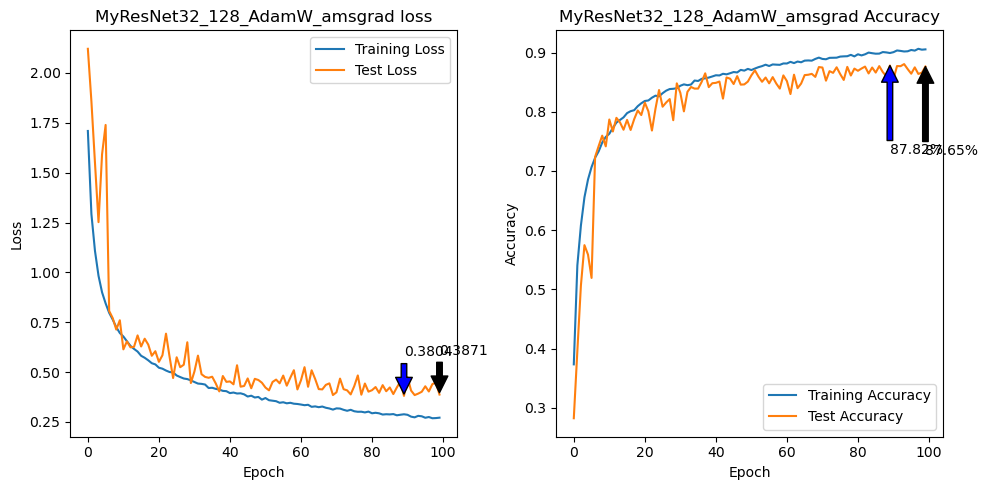

In [17]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [18]:
view.print_all()

1 epoch: train_loss=1.7091, train_acc=0.3733, test_loss=2.1212, test_acc=0.2822, lr=0.0010
2 epoch: train_loss=1.2926, train_acc=0.5404, test_loss=1.8576, test_acc=0.3958, lr=0.0010
3 epoch: train_loss=1.1080, train_acc=0.6078, test_loss=1.5500, test_acc=0.5064, lr=0.0010
4 epoch: train_loss=0.9828, train_acc=0.6556, test_loss=1.2518, test_acc=0.5747, lr=0.0010
5 epoch: train_loss=0.8998, train_acc=0.6856, test_loss=1.5926, test_acc=0.5587, lr=0.0010
6 epoch: train_loss=0.8444, train_acc=0.7066, test_loss=1.7393, test_acc=0.5193, lr=0.0010
7 epoch: train_loss=0.7971, train_acc=0.7224, test_loss=0.8063, test_acc=0.7238, lr=0.0010
8 epoch: train_loss=0.7631, train_acc=0.7332, test_loss=0.7705, test_acc=0.7421, lr=0.0010
9 epoch: train_loss=0.7251, train_acc=0.7480, test_loss=0.7130, test_acc=0.7597, lr=0.0010
10 epoch: train_loss=0.6958, train_acc=0.7575, test_loss=0.7598, test_acc=0.7416, lr=0.0010
11 epoch: train_loss=0.6783, train_acc=0.7629, test_loss=0.6138, test_acc=0.7870, lr=0.00